# 1. Setup

In [ ]:
import os
print("Current directory:", os.getcwd())
print("Files in current directory:")
for item in os.listdir('.'):
    if os.path.isfile(item):
        print(f"  {item}")


Already up to date.
Content of dir:
total 216
drwxr-xr-x  3663 davide  staff  117216 27 Nov 13:49 dataset
-rw-r--r--     1 davide  staff  110184 27 Nov 13:49 dataset.csv


In [ ]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split

data = pd.read_csv('dataset.csv')
data['class_combined'] = data['type'] + '_' + data['state']

X = data[['name']]
y = data['class_combined']

random_state = 17

X_temp, X_test, y_temp, y_test = train_test_split(
 X, y,
 test_size=0.15,
 random_state=random_state,
 stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
 X_temp, y_temp,
 test_size=0.176,
 random_state=random_state,
 stratify=y_temp
)

print("Train size:", len(X_train))
print("Validation size:", len(X_val))
print("Test size:", len(X_test))


Train size: 2564
Validation size: 548
Test size: 550


# 2. Aug 

In [ ]:
import os
import numpy as np
from PIL import Image

import torchvision.transforms as T
import torch

size = 128

normalize = T.Compose([
 T.ToTensor(),
])

val_transform = T.Compose([
 T.Resize((size, size)),
 normalize,
])

aug_1 = T.Compose([
 T.Resize((size, size)),
 T.RandomHorizontalFlip(0.5),
 T.RandomRotation(10),
 T.ColorJitter(brightness=0.1, contrast=0.1),
 normalize
])

aug_2 = T.Compose([
 T.Resize((size, size)),
 T.RandomVerticalFlip(0.5),
 T.RandomRotation(10),
 T.ColorJitter(brightness=0.1, contrast=0.1),
 normalize
])

aug_3 = T.Compose([
 T.Resize((size, size)),
 T.RandomHorizontalFlip(0.3),
 T.RandomVerticalFlip(0.3),
 T.RandomRotation(5),
 T.ColorJitter(brightness=0.07, contrast=0.07),
 normalize
])

aug_blur = T.Compose([
 T.Resize((size, size)),
 T.GaussianBlur(kernel_size=3, sigma=(0.1, 1.0)),
 T.RandomHorizontalFlip(0.4),
 T.ColorJitter(brightness=0.08, contrast=0.08),
 normalize
])

aug_crop = T.Compose([
 T.RandomResizedCrop(size, scale=(0.85, 1.0), ratio=(0.95, 1.05)),
 T.RandomHorizontalFlip(0.4),
 T.RandomRotation(8),
 T.ColorJitter(brightness=0.1, contrast=0.1),
 normalize
])

aug_noise = T.Compose([
 T.Resize((size, size)),
 T.RandomHorizontalFlip(0.3),
 T.ColorJitter(brightness=0.12, contrast=0.12, saturation=0.1),
 T.RandomRotation(7),
 normalize
])

train_transform = [val_transform, aug_1, aug_2, aug_3, aug_blur, aug_crop, aug_noise, aug_3]

def load_images_as_numpy(df, labels, root_dir, transform):
 X_list = []
 y_list = []
 for i in range(len(df)):
  img_path = os.path.join(root_dir, df.iloc[i]["name"])
  img = Image.open(img_path).convert("RGB")
  if isinstance(transform, list):
   for t in transform:
    img_t = t(img)
    img_np = img_t.numpy()
    X_list.append(img_np)
    y_list.append(labels.iloc[i])
  else:
   img_t = transform(img)
   img_np = img_t.numpy()
   X_list.append(img_np)
   y_list.append(labels.iloc[i])
 
 X = np.stack(X_list, axis=0)
 y = np.array(y_list)
 return X, y

root_dir = "datasetV1"
X_val_np, y_val_np = load_images_as_numpy(X_val, y_val, root_dir, val_transform)
X_test_np, y_test_np = load_images_as_numpy(X_test, y_test, root_dir, val_transform)

print(X_train_np.shape, y_train_np.shape)
print(X_val_np.shape, y_val_np.shape)
print(X_test_np.shape, y_test_np.shape)


(20512, 3, 128, 128) (20512,)
(548, 3, 128, 128) (548,)
(550, 3, 128, 128) (550,)


# 3. Feature Extraction on "Clean" Data (De-augmentation)
**Obiettivo**: Analizzare la distribuzione reale dei dati, senza il rumore introdotto dall'augmentation.
**Metodologia**:
- Il `DataLoader` potrebbe aver caricato versioni aumentate (duplicate) delle immagini.
- Selezioniamo solo gli indici univoci (`X_train_unique`) per lavorare sul dataset originale.
- Estraiamo feature artigianali (**Color Histogram HSV** + **LBP Texture**) per avere una rappresentazione numerica compatta delle immagini (64 feature totali).
- Standardizziamo i dati (`StandardScaler`) perché algoritmi come PCA e DBSCAN sono sensibili alla scala delle variabili.


In [4]:
import numpy as np
import cv2
from skimage.color import rgb2gray
from skimage.feature import local_binary_pattern
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

def color_hist_from_np(img_np, bins=16):
    img = img_np.reshape(3, 128, 128)
    img = np.transpose(img, (1, 2, 0))
    img = np.clip(img, 0.0, 1.0)
    img_hsv = cv2.cvtColor((img * 255.0).astype(np.uint8), cv2.COLOR_RGB2HSV)
    h, s, v = cv2.split(img_hsv)
    h = h.astype(np.float32) / 255.0
    s = s.astype(np.float32) / 255.0
    v = v.astype(np.float32) / 255.0
    bin_edges = np.linspace(0.0, 1.0, bins + 1)
    hists = []
    for ch in (h, s, v):
        hist, _ = np.histogram(ch.ravel(), bins=bin_edges, density=True)
        hists.append(hist)
    return np.concatenate(hists).astype(np.float32)

def lbp_from_np(img_np, P=8, R=1, n_bins=16):
    img = img_np.reshape(3, 128, 128)
    img = np.transpose(img, (1, 2, 0))
    img = np.clip(img, 0.0, 1.0)
    gray = rgb2gray(img)
    lbp = local_binary_pattern(gray, P=P, R=R, method="uniform")
    lbp = lbp.astype(np.float32)
    lbp_norm = lbp / (lbp.max() + 1e-8)
    hist, _ = np.histogram(lbp_norm.ravel(), bins=n_bins, range=(0.0, 1.0), density=True)
    return hist.astype(np.float32)

def extract_feat_single(img_np):
    color_f = color_hist_from_np(img_np, bins=16)
    lbp_f = lbp_from_np(img_np, P=8, R=1, n_bins=16)
    return np.concatenate([color_f, lbp_f])

X_train_unique_idx = np.arange(0, len(X_train_np), 8)
X_train_unique = X_train_np[X_train_unique_idx]
y_train_unique = y_train_np[X_train_unique_idx]

print(f"Original X_train (augmented): {X_train_np.shape}")
print(f"X_train unique (de-augmented): {X_train_unique.shape}")
print()

X_train_cl_clean = np.array([extract_feat_single(X_train_unique[i]) for i in range(X_train_unique.shape[0])])
X_val_cl_clean = np.array([extract_feat_single(X_val_np[i]) for i in range(X_val_np.shape[0])])
X_test_cl_clean = np.array([extract_feat_single(X_test_np[i]) for i in range(X_test_np.shape[0])])

scaler_clean = StandardScaler()
X_train_cl_clean_std = scaler_clean.fit_transform(X_train_cl_clean)
X_val_cl_clean_std = scaler_clean.transform(X_val_cl_clean)
X_test_cl_clean_std = scaler_clean.transform(X_test_cl_clean)

print("="*70)
print("SETUP DATI PULITI (de-augmentati, senza duplicati)")
print("="*70)
print(f"X_train_cl_clean_std: {X_train_cl_clean_std.shape}")
print(f"X_val_cl_clean_std:   {X_val_cl_clean_std.shape}")
print(f"X_test_cl_clean_std:  {X_test_cl_clean_std.shape}")
print(f"Feature per immagine: {X_train_cl_clean_std.shape[1]} (48 color HSV + 16 LBP)")
print(f"y_train_unique shape: {y_train_unique.shape}")
print("="*70)


Original X_train (augmented): (20512, 3, 128, 128)
X_train unique (de-augmented): (2564, 3, 128, 128)



/opt/homebrew/Caskroom/miniconda/base/envs/ml/lib/python3.11/site-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


SETUP DATI PULITI (de-augmentati, senza duplicati)
X_train_cl_clean_std: (2564, 64)
X_val_cl_clean_std:   (548, 64)
X_test_cl_clean_std:  (550, 64)
Feature per immagine: 64 (48 color HSV + 16 LBP)
y_train_unique shape: (2564,)


# 4. Statistical Analysis: Pixel-Level RGB Distribution
**Obiettivo**: Verificare se le classi sono separabili guardando solo alle statistiche grezze dei pixel.
**Metodologia**:
- Calcoliamo media e deviazione standard dei canali R, G, B per ogni immagine.
- Visualizziamo i **Boxplot** per classe.
- **Interpretazione**: Se i boxplot di due classi (es. `apple_healthy` vs `tomato_healthy`) sono completamente sovrapposti, significa che il colore medio non basta a distinguerle e serviranno feature più complesse (texture o forma).


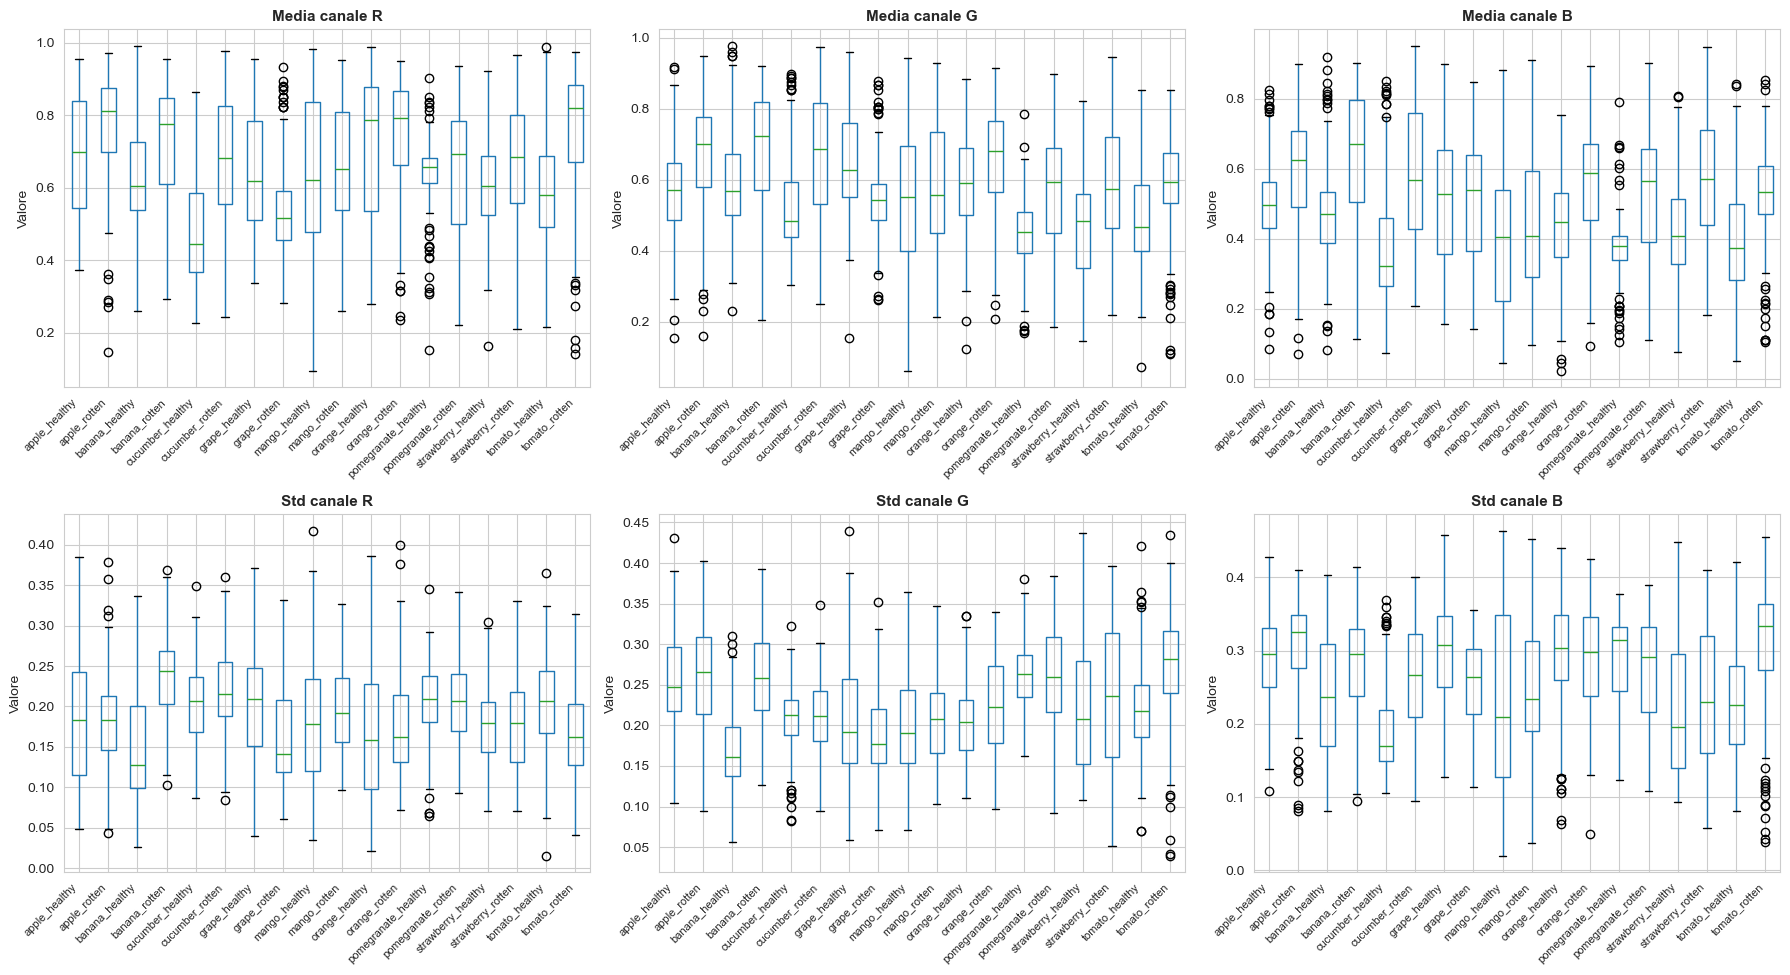


STATISTICHE PIXEL-LEVEL (media per canale RGB)
                       mean_R    mean_G    mean_B
class                                            
apple_healthy        0.689832  0.569766  0.499320
apple_rotten         0.764606  0.671929  0.589080
banana_healthy       0.652064  0.603696  0.475592
banana_rotten        0.723778  0.683782  0.640272
cucumber_healthy     0.485410  0.529899  0.388667
cucumber_rotten      0.679043  0.675845  0.587278
grape_healthy        0.643045  0.653527  0.509417
grape_rotten         0.543060  0.548420  0.509036
mango_healthy        0.646987  0.558084  0.402985
mango_rotten         0.663423  0.589553  0.452548
orange_healthy       0.727056  0.585701  0.431957
orange_rotten        0.748149  0.644676  0.558294
pomegranate_healthy  0.637411  0.443054  0.373024
pomegranate_rotten   0.649944  0.568804  0.519923
strawberry_healthy   0.592533  0.455573  0.409940
strawberry_rotten    0.681458  0.589460  0.567365
tomato_healthy       0.603997  0.485272  0.395157
to

In [5]:
def extract_pixel_stats(X_np):
    N = X_np.shape[0]
    stats = np.zeros((N, 6))
    for i in range(N):
        img = X_np[i].reshape(3, 128, 128)
        img = np.transpose(img, (1, 2, 0))
        img = np.clip(img, 0.0, 1.0)
        for ch in range(3):
            stats[i, ch] = img[:, :, ch].mean()
            stats[i, ch+3] = img[:, :, ch].std()
    return stats

pixel_stats_train = extract_pixel_stats(X_train_unique)

df_stats = pd.DataFrame(pixel_stats_train, columns=['mean_R', 'mean_G', 'mean_B', 'std_R', 'std_G', 'std_B'])
df_stats['class'] = y_train_unique

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

stats_cols = ['mean_R', 'mean_G', 'mean_B', 'std_R', 'std_G', 'std_B']
titles = ['Media canale R', 'Media canale G', 'Media canale B', 
          'Std canale R', 'Std canale G', 'Std canale B']

for idx, (col, title) in enumerate(zip(stats_cols, titles)):
    ax = axes[idx // 3, idx % 3]
    df_stats.boxplot(column=col, by='class', ax=ax)
    ax.set_title(title, fontsize=11, fontweight='bold')
    ax.set_xlabel('')
    ax.set_ylabel('Valore')
    plt.sca(ax)
    plt.xticks(rotation=45, ha='right', fontsize=8)

plt.suptitle('')
plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("STATISTICHE PIXEL-LEVEL (media per canale RGB)")
print("="*70)
summary_stats = df_stats.groupby('class')[['mean_R', 'mean_G', 'mean_B']].mean()
print(summary_stats)

# 5. Dimensionality Reduction: Visualizing the Feature Space
**Obiettivo**: Proiettare le 64 dimensioni delle feature in 2D per "vedere" la struttura del dataset.
**Confronto Metodi**:
1.  **t-SNE (t-Distributed Stochastic Neighbor Embedding)**:
    - Ottimo per vedere la struttura *locale* e i cluster non lineari.
    - Se vediamo "isole" ben separate, il dataset è facile. Se è un "blob" unico, è difficile.
2.  **PCA (Principal Component Analysis)**:
    - Proiezione lineare che massimizza la varianza globale.
    - Ci dice se le direzioni principali di variazione dei dati corrispondono alle classi.
**Cosa cerchiamo**: Sovrapposizioni tra classi (es. frutti rossi mischiati tra loro) che indicano potenziali difficoltà di classificazione.


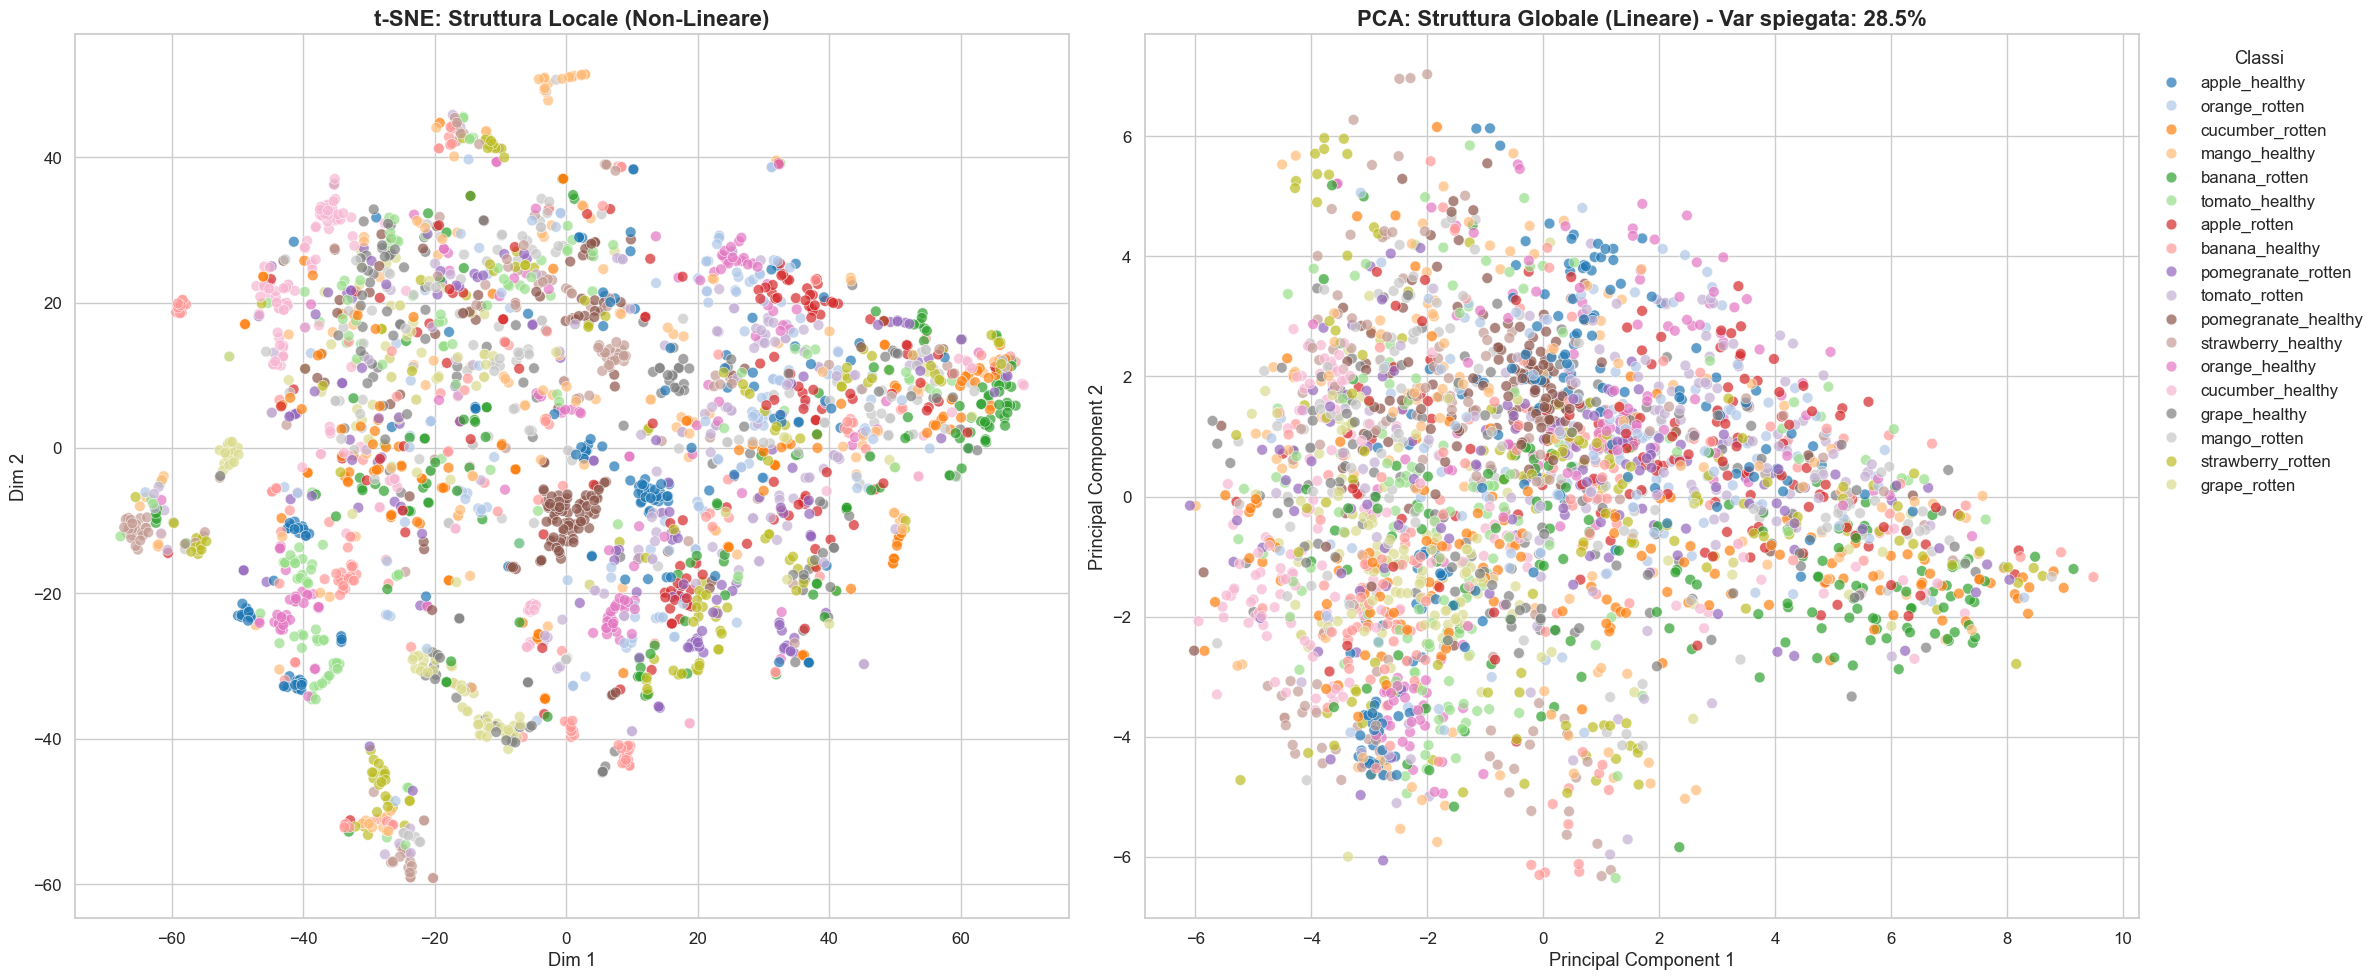

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Setup estetico per grafici "da pubblicazione"
sns.set_theme(style="whitegrid", context="notebook", font_scale=1.1)

# 1. Calcolo t-SNE (Topology preservation)
# perplexity=30 è un buon compromesso per ~2500 punti. init='pca' stabilizza il risultato.
tsne = TSNE(n_components=2, perplexity=30, max_iter=1000, random_state=42, init='pca', learning_rate='auto')
X_tsne = tsne.fit_transform(X_train_cl_clean_std)

# 2. Calcolo PCA (Variance preservation)
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_train_cl_clean_std)
var_pca = pca.explained_variance_ratio_.sum() * 100

# 3. Creazione Plot Side-by-Side
fig, axes = plt.subplots(1, 2, figsize=(24, 10))

# --- Plot Sinistra: t-SNE ---
sns.scatterplot(
    x=X_tsne[:, 0], y=X_tsne[:, 1],
    hue=y_train_unique,
    palette="tab20",      # Palette ad alto contrasto per molte classi
    s=60, alpha=0.7,      # Dimensione e trasparenza punti
    edgecolor="w", linewidth=0.5,
    legend=False,         # Niente legenda qui per pulizia
    ax=axes[0]
)
axes[0].set_title("t-SNE: Struttura Locale (Non-Lineare)", fontsize=16, weight='bold')
axes[0].set_xlabel("Dim 1")
axes[0].set_ylabel("Dim 2")

# --- Plot Destra: PCA ---
scatter = sns.scatterplot(
    x=X_pca[:, 0], y=X_pca[:, 1],
    hue=y_train_unique,
    palette="tab20",
    s=60, alpha=0.7,
    edgecolor="w", linewidth=0.5,
    ax=axes[1]
)
axes[1].set_title(f"PCA: Struttura Globale (Lineare) - Var spiegata: {var_pca:.1f}%", fontsize=16, weight='bold')
axes[1].set_xlabel("Principal Component 1")
axes[1].set_ylabel("Principal Component 2")

# Sposta la legenda fuori dal grafico a destra per non coprire i dati
sns.move_legend(axes[1], "upper left", bbox_to_anchor=(1, 1), title="Classi", frameon=False)

plt.tight_layout()
plt.show()


# 6. Outlier Detection Strategy (Step A: k-Distance)
**Obiettivo**: Configurare i parametri per l'algoritmo di clustering DBSCAN.
**Problema**: DBSCAN richiede un parametro `eps` (raggio di vicinato) difficile da indovinare.
**Soluzione**:
- Usiamo il metodo del **k-Distance Graph** (con k=5).
- Calcoliamo la distanza dal 5° vicino per ogni punto e le ordiniamo.
- Il punto di "gomito" (knee) del grafico ci suggerisce il valore ottimale di `eps`: dove la curva impenna, iniziano gli outlier (punti troppo isolati).


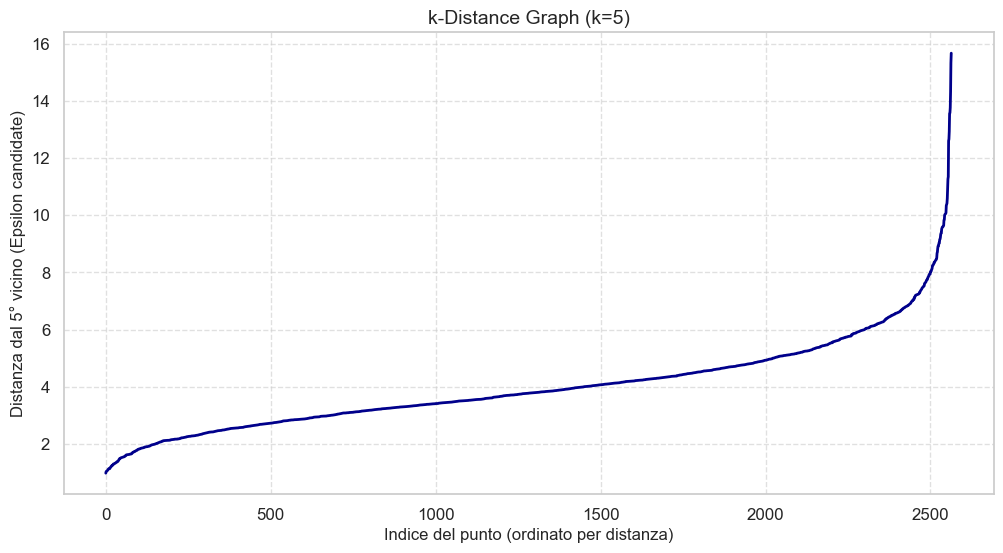

In [11]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

# Setup
k = 5  # Standard per cercare outlier locali
nbrs = NearestNeighbors(n_neighbors=k).fit(X_train_cl_clean_std)

# Calcoliamo la distanza di ogni punto dal suo 5° vicino più prossimo
distances, indices = nbrs.kneighbors(X_train_cl_clean_std)

# Ordiniamo le distanze per visualizzare il "gomito"
k_distances = np.sort(distances[:, k-1])

# Plot
plt.figure(figsize=(12, 6))
plt.plot(k_distances, linewidth=2, color='darkblue')

# Aggiungiamo griglia e label per facilitare la lettura
plt.title(f"k-Distance Graph (k={k})", fontsize=14)
plt.xlabel("Indice del punto (ordinato per distanza)", fontsize=12)
plt.ylabel(f"Distanza dal {k}° vicino (Epsilon candidate)", fontsize=12)
plt.grid(True, which="both", linestyle="--", alpha=0.6)

# Zoom sulla parte finale (opzionale, ma spesso utile se ci sono outlier estremi)
# plt.ylim(0, 30) # Decommenta se hai outlier che schiacciano troppo il grafico

plt.show()


# 7. Outlier Detection (Step B: DBSCAN)
**Obiettivo**: Identificare e isolare immagini "sporche" o anomale che potrebbero confondere il modello.
**Algoritmo**: DBSCAN (Density-Based Spatial Clustering of Applications with Noise).
- I punti in zone dense sono considerati "core" (dati buoni).
- I punti isolati che non rientrano in nessun cluster denso vengono etichettati come **Noise (-1)**.
- **Analisi**: Contiamo quanti outlier ci sono per classe. Se una classe ha troppi outlier (es. `strawberry_healthy`), potrebbe indicare che le immagini di quella classe sono molto eterogenee o di bassa qualità.


Eseguo DBSCAN con eps=7.0, min_samples=5...
Risultati DBSCAN:
- Totale campioni: 2564
- Outliers rilevati: 68 (2.65%)

Top 5 Classi con più outlier (potenziali immagini 'sporche'):
label
strawberry_healthy    9
banana_rotten         8
cucumber_rotten       8
banana_healthy        6
mango_healthy         6
Name: count, dtype: int64


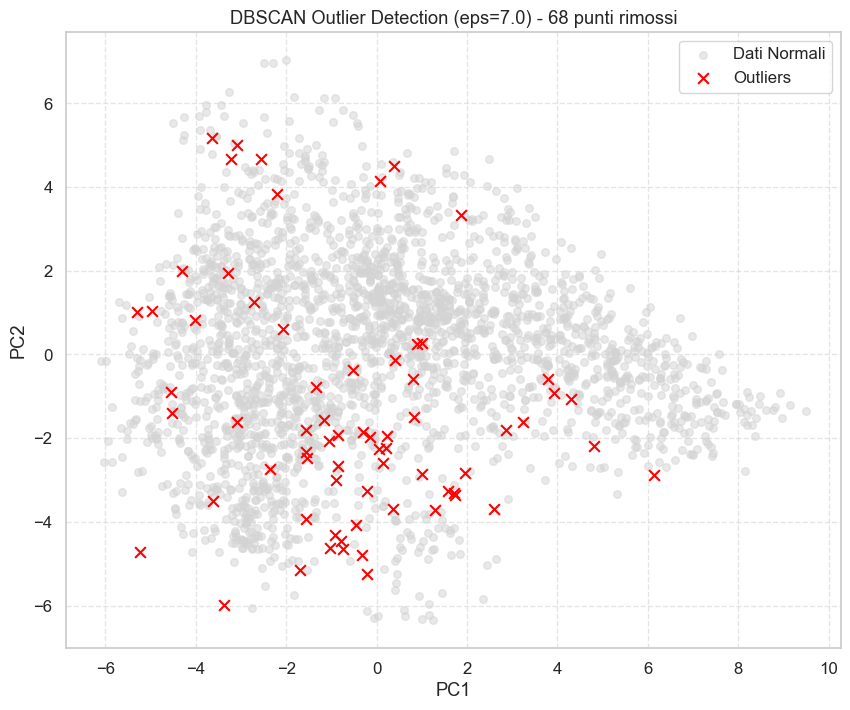

In [12]:
from sklearn.cluster import DBSCAN
import pandas as pd

# Impostiamo epsilon basandoci sulla tua osservazione
eps_value = 7.0
min_samples = 5  # Stesso k usato sopra

print(f"Eseguo DBSCAN con eps={eps_value}, min_samples={min_samples}...")

# Fitting del modello
db = DBSCAN(eps=eps_value, min_samples=min_samples).fit(X_train_cl_clean_std)
labels_db = db.labels_

# Calcoliamo le statistiche
n_outliers = np.sum(labels_db == -1)
pct_outliers = (n_outliers / len(labels_db)) * 100

print(f"Risultati DBSCAN:")
print(f"- Totale campioni: {len(labels_db)}")
print(f"- Outliers rilevati: {n_outliers} ({pct_outliers:.2f}%)")

# Analisi: Chi sono questi outlier?
df_noise = pd.DataFrame({'label': y_train_unique, 'cluster': labels_db})
outliers_per_class = df_noise[df_noise['cluster'] == -1]['label'].value_counts()

print("\nTop 5 Classi con più outlier (potenziali immagini 'sporche'):")
print(outliers_per_class.head(5))

# Visualizziamo gli outlier sovrapposti alla PCA (che abbiamo già calcolato come X_pca)
plt.figure(figsize=(10, 8))

# 1. Plot punti normali (grigi, trasparenti)
mask_clean = labels_db != -1
plt.scatter(X_pca[mask_clean, 0], X_pca[mask_clean, 1], 
            c='lightgray', alpha=0.5, s=30, label='Dati Normali')

# 2. Plot outlier (rossi, ben visibili)
mask_noise = labels_db == -1
plt.scatter(X_pca[mask_noise, 0], X_pca[mask_noise, 1], 
            c='red', marker='x', s=60, linewidth=1.5, label='Outliers')

plt.title(f"DBSCAN Outlier Detection (eps={eps_value}) - {n_outliers} punti rimossi")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


# 8. Baseline Evaluation: Random Forest on Handcrafted Features
**Obiettivo**: Stabilire una "baseline" di performance sui dati puliti.
**Metodologia**:
- Addestriamo un Random Forest semplice sulle feature estratte (Color+LBP).
- Analizziamo la **Confusion Matrix** sul Validation Set.
- **Utilità**: Questo ci dice il "minimo sindacale" che possiamo aspettarci. Gli errori che vediamo qui (es. confusione mela/pomodoro) sono quelli "strutturali" che cercheremo di risolvere dopo con modelli più complessi o augmentation.


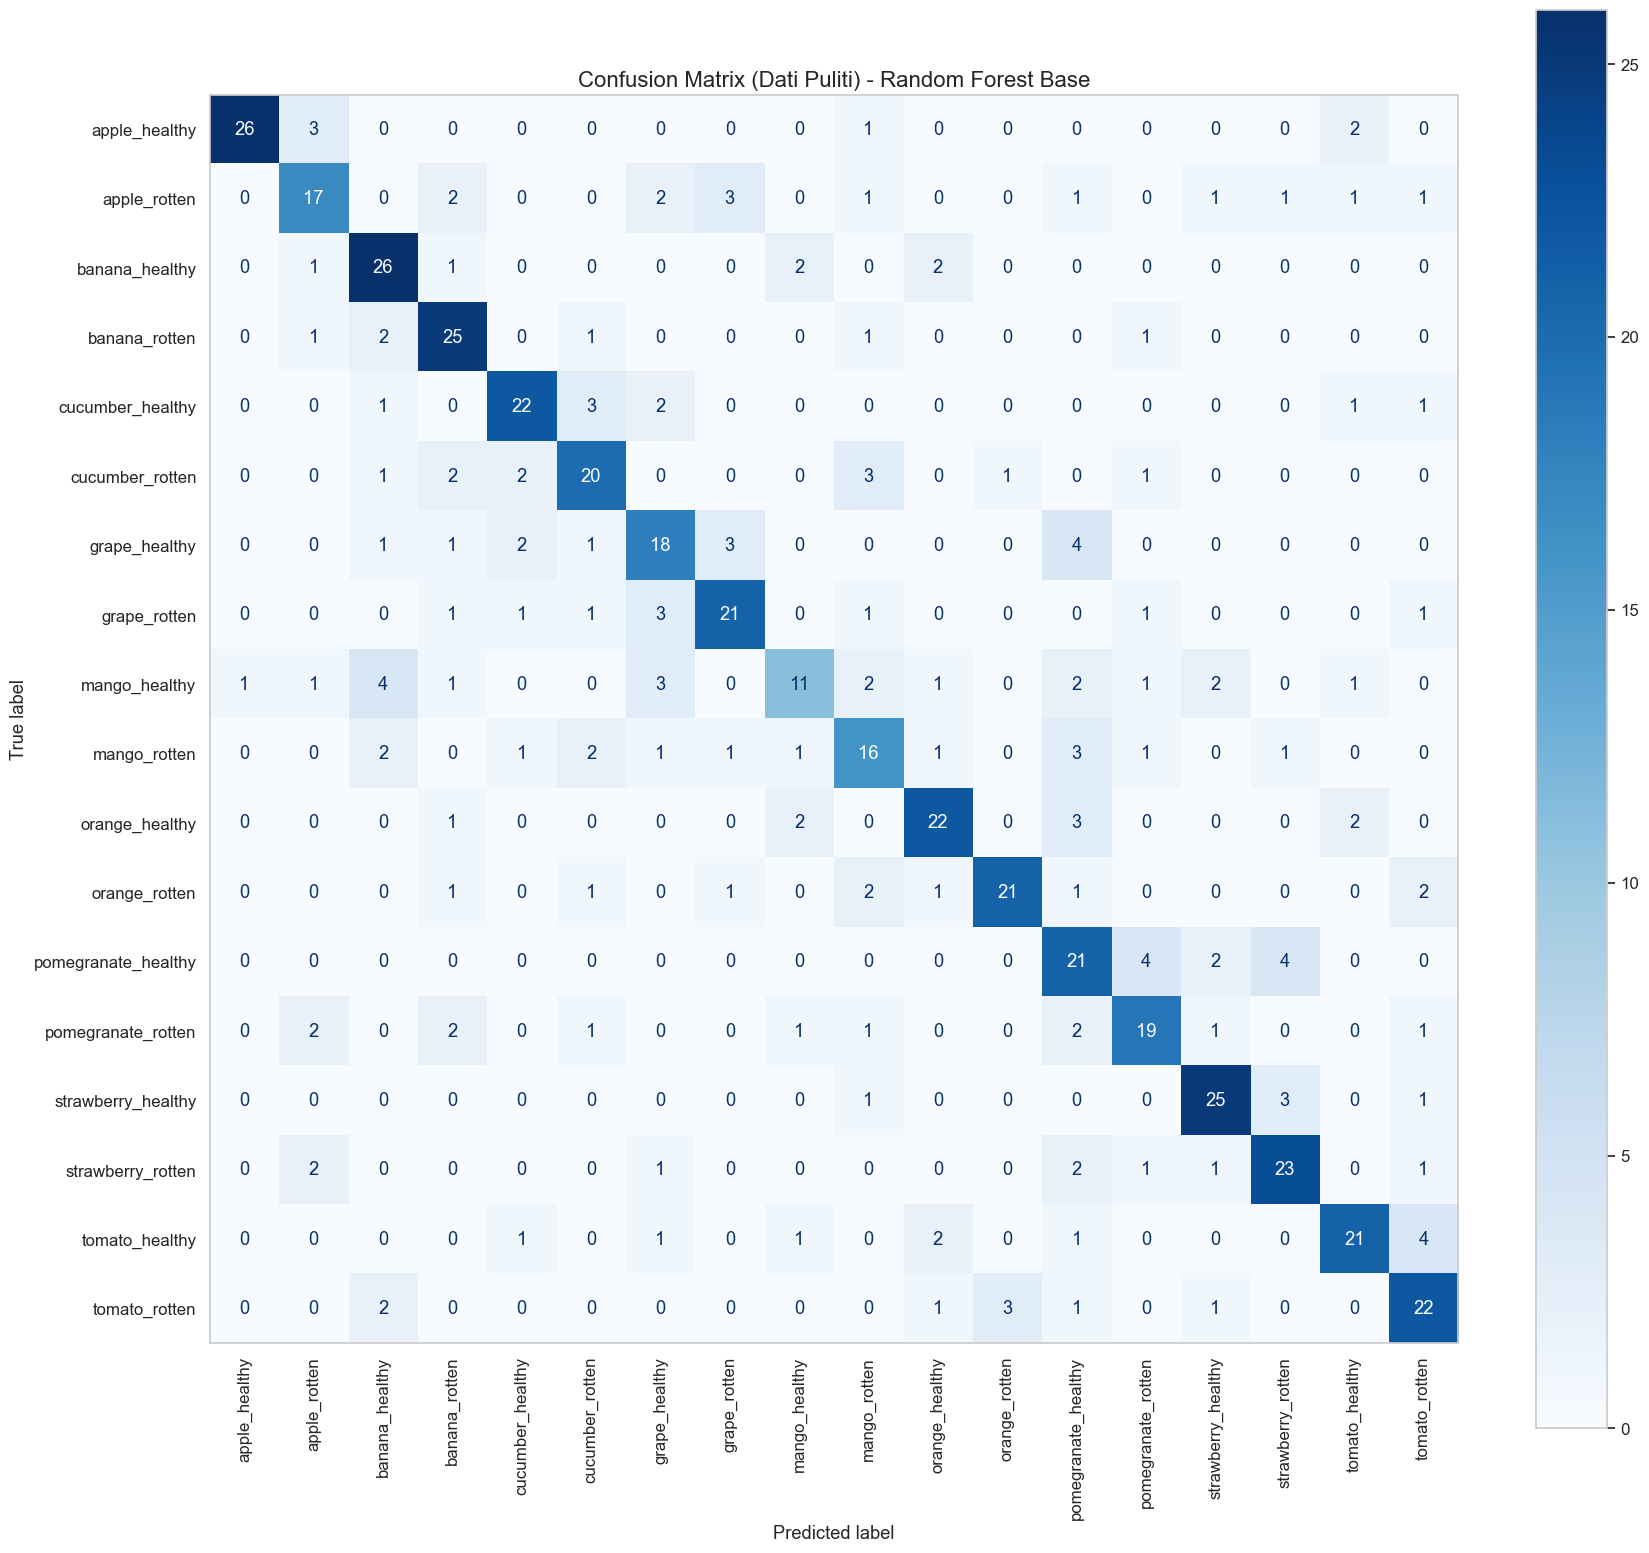


Classification Report:
                     precision    recall  f1-score   support

      apple_healthy       0.96      0.81      0.88        32
       apple_rotten       0.63      0.57      0.60        30
     banana_healthy       0.67      0.81      0.73        32
      banana_rotten       0.68      0.81      0.74        31
   cucumber_healthy       0.76      0.73      0.75        30
    cucumber_rotten       0.67      0.67      0.67        30
      grape_healthy       0.58      0.60      0.59        30
       grape_rotten       0.72      0.70      0.71        30
      mango_healthy       0.61      0.37      0.46        30
       mango_rotten       0.55      0.53      0.54        30
     orange_healthy       0.73      0.73      0.73        30
      orange_rotten       0.84      0.70      0.76        30
pomegranate_healthy       0.51      0.68      0.58        31
 pomegranate_rotten       0.66      0.63      0.64        30
 strawberry_healthy       0.76      0.83      0.79        30

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import numpy as np

rf_explore = RandomForestClassifier(n_estimators=100, random_state=random_state, n_jobs=-1)
rf_explore.fit(X_train_cl_clean_std, y_train_unique)

y_val_pred = rf_explore.predict(X_val_cl_clean_std)

# 3. Visualizzazione
fig, ax = plt.subplots(figsize=(18, 16)) # Aumentato leggermente per leggibilità

# Le label da visualizzare sono le classi uniche presenti
classes_to_plot = np.unique(y_train_unique)

cm = confusion_matrix(y_val_np, y_val_pred, labels=classes_to_plot)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes_to_plot)
disp.plot(cmap='Blues', ax=ax, xticks_rotation='vertical', values_format='d')

plt.title("Confusion Matrix (Dati Puliti) - Random Forest Base", fontsize=16)
plt.grid(False)
plt.tight_layout()
plt.show()

# Report testuale per i dettagli
print("\nClassification Report:")
print(classification_report(y_val_np, y_val_pred))


# 9. Feature Importance Analysis (PCA Biplot)
**Obiettivo**: Capire QUALI feature (Colore vs Texture) guidano la separazione dei dati.
**Metodologia**:
- Il **Biplot** sovrappone i vettori delle feature (frecce) allo scatter plot dei dati.
- **Lettura**:
    - La lunghezza della freccia indica l'importanza della feature.
    - La direzione indica verso quale cluster la feature "tira".
    - *Esempio*: Se le frecce `LBP` puntano verso i frutti marci, significa che la texture è fondamentale per rilevare il deterioramento.


Visualizzate 25 feature su 64 (soglia=0.5)


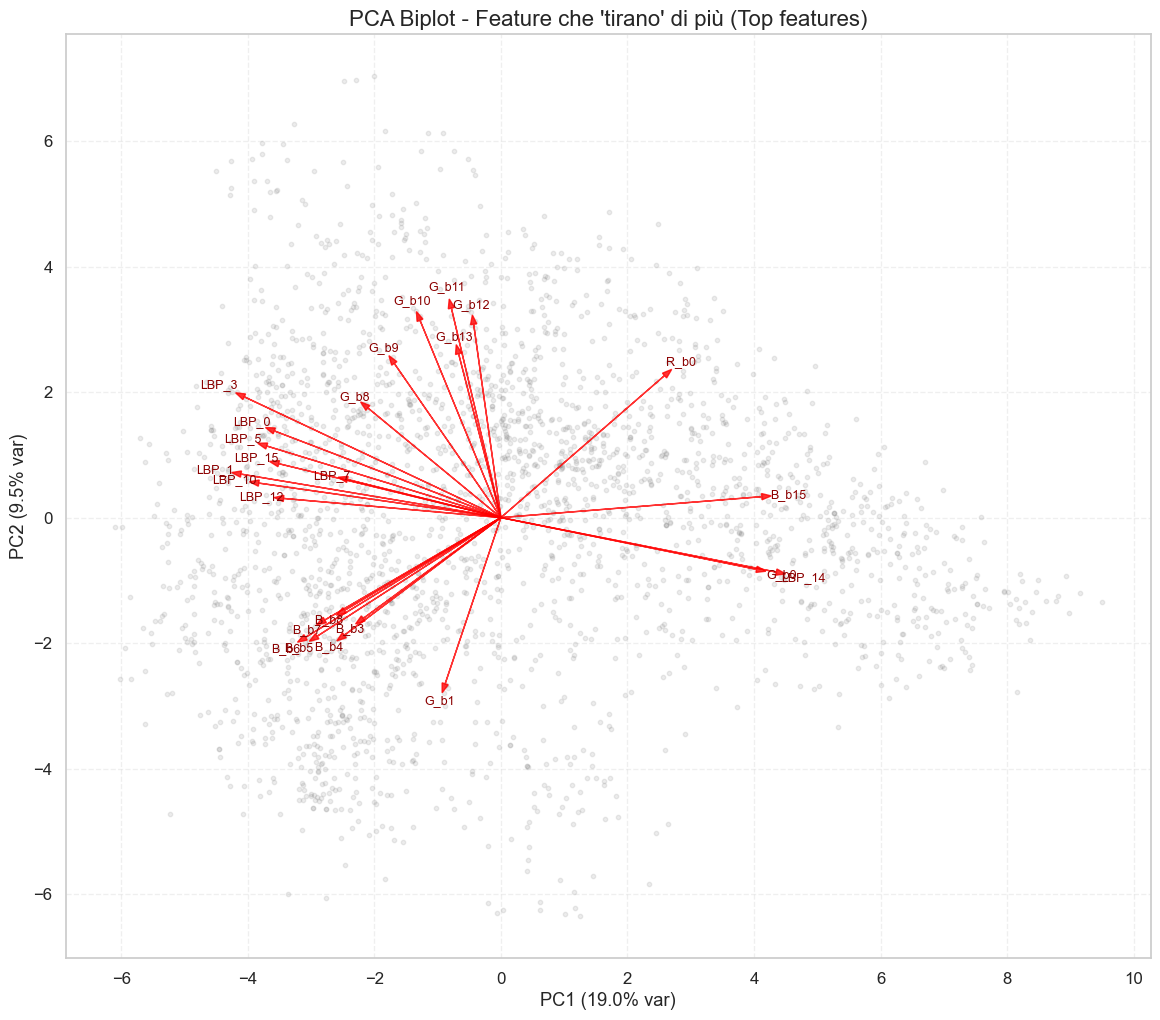

In [17]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Nomi delle feature (ricostruiti dalla logica di estrazione)
# 16 bin per 3 canali colore + 16 bin LBP = 64 feature
feat_names = []
channels = ['R', 'G', 'B'] # Assumiamo RGB
for c in channels:
    for i in range(16):
        feat_names.append(f"{c}_b{i}")
for i in range(16):
    feat_names.append(f"LBP_{i}")

# PCA su 2 componenti
pca_biplot = PCA(n_components=2)
X_pca_bi = pca_biplot.fit_transform(X_train_cl_clean_std)
loadings = pca_biplot.components_.T * np.sqrt(pca_biplot.explained_variance_)

plt.figure(figsize=(14, 12))

# 1. Plot dei punti (molto trasparenti per dare contesto)
plt.scatter(X_pca_bi[:, 0], X_pca_bi[:, 1], alpha=0.15, c='gray', s=10)

# 2. Plot dei vettori (frecce)
# Filtriamo solo le feature con un peso significativo per non intasare il grafico
threshold = 0.5  # Soglia di visibilità (aggiusta se vedi troppe/poche frecce)
count_arrows = 0

for i, feature in enumerate(feat_names):
    # Lunghezza del vettore
    length = np.sqrt(loadings[i, 0]**2 + loadings[i, 1]**2)
    
    if length > threshold:
        count_arrows += 1
        plt.arrow(0, 0, loadings[i, 0]*5, loadings[i, 1]*5, 
                  color='red', alpha=0.8, head_width=0.1)
        # Testo spostato leggermente oltre la punta
        plt.text(loadings[i, 0]*5.5, loadings[i, 1]*5.5, feature, 
                 color='darkred', fontsize=9, ha='center', va='center')

plt.title(f"PCA Biplot - Feature che 'tirano' di più (Top features)", fontsize=16)
plt.xlabel(f"PC1 ({pca_biplot.explained_variance_ratio_[0]:.1%} var)")
plt.ylabel(f"PC2 ({pca_biplot.explained_variance_ratio_[1]:.1%} var)")
plt.grid(True, linestyle='--', alpha=0.3)

print(f"Visualizzate {count_arrows} feature su 64 (soglia={threshold})")
plt.show()
